# Classification of b-quark jets in the Aleph simulated data

The following is an introduction to using Machine Learning (ML) - in particular Boosted Decision Trees (BDT) - for trying to determine, if an entry in a data file is of one type (signal, ill, guilty, etc.) or another (background, healthy, innocent, etc.).

You may choose between two data samples:
1. A particle physics dataset containing simulated decays of the $Z^0$ boson decaying to a quark and an anti-quark producing two "jets" of particles. The question is, if the jets are from a b-quark (b-jet) or from lighter quarks (l-jet).
3. A "medical" dataset which concers a lifestyle disease in relation to various (transformed) lifestyle variables (reduced in number of variables to match the Aleph b-jet data set).

In the following, we discuss the problem from the b-jet point of view, as this is where the largest size datasets are available. However, we stress that from the point of view of ML, data content (what is being considered) is not essential to know (for now!!!). And knowing the content in details requires domain knowledge, i.e. that you are an expert in the specific field, that the data comes from. This part is very important, but not the focus in this course.

In the end, this exercise is the simple start "outside ML" and moving into the territory of Machine Learning analysis.

### The Data:
The input variables (X) are (used by Aleph for their NN):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).

Auxilary variables (Z) are (not used by Aleph for their NN):
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the Aleph detector was essentially uniform in phi, this should not matter (much).

The target variable (Y) is:
* **isb**:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* **nnbjet**: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).

In case you choose **the medical data**, the variables to use as input (X) are: **Qsocial, BMI, Roccupat, Rgenetic, Rdietary, and Rhormonn** (reflecting Quantiles and Ratios of medical measurements). The target variable (Y) is (naturally): **TrulyIll**, and you can compare your results to the average of doctors: **DocScore**.


## The Task this weak:

### HyperParameter optimization (here for LightGBM model):

The following exercise is about HyperParameter (HP) optimization. Your task is to find the HPs that gives the best performance for your model. In order to avoid statistical fluctuations we use 50000 events (but you may eventually decide to use more).

The are many things to tune in LigthGBM, see this long [list of HPs for LightGBM algorithm](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html). In order to limit ourselves, you should in the following only consider (at least to begin with) the following five HPs:

* Number of tree
* Number of leaves
* Learning rate
* Boosting (how to combine trees: 1. Traditional Gradient Boosting, Random Forest, or [DART](https://arxiv.org/abs/1505.01866))
* Minimum data in each leave (use this to avoid over-fitting)

The purpose is to get the best possible performance out.


* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   15th of April 2025

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
import pandas as pd 
from pandas import Series, DataFrame 
from matplotlib import pyplot as plt
import numpy as np

SavePlots = False

## Import and inspect the data:

In [2]:
# Read the data and print the variables:
data = pd.DataFrame(np.genfromtxt('../Week1/AlephBtag_MC_train_Nev50000.csv', names=True))
# data = pd.DataFrame(np.genfromtxt('../Week1/Medical_Npatients50000.csv', names=True))

variables = data.columns
print(variables.values)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print("  Variables used for training: ", input_variables.values)

['energy' 'cTheta' 'phi' 'prob_b' 'spheri' 'pt2rel' 'multip' 'bqvjet'
 'ptlrel' 'nnbjet' 'isb']
  Variables used for training:  ['prob_b' 'spheri' 'pt2rel' 'multip' 'bqvjet' 'ptlrel']


## Training set-up
First we import the necessary packages and split the data set into training and test set. We choose a 75:25 division here. 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping
import time

# Dataset is shuffeled before the split (to avoid any ordering). By using a fixed
# We choose a random seed number (42), so that  we can rerun and obtain the same result (for reproducibility!).
input_train, input_test, truth_train, truth_test, benchmark_train, benchmark_test = \
    train_test_split(input_data, truth_data, benchmark_data, test_size=0.25, random_state=42)

# Feed the datasets to LightGBM:
lgb_train = lgb.Dataset(input_train, truth_train)
lgb_eval  = lgb.Dataset(input_test,  truth_test, reference=lgb_train)

### Selection of hyperparameters 
Now, comes the important part: **Choosing the right hyperparameters**

1. <code>boosting</code>: (default = gbdt) <br>
    <code>gbdt</code> --> traditional Gradient Boosting Decision Tree<br>
    <code>rf</code> --> Random Forest (bagging, not boosting)<br>
    <code>dart</code> --> [Dropouts meet Multiple Additive Regression Trees](https://arxiv.org/abs/1505.01866) (drops some trees during training) <br>

2. <code>learning_rate</code>: (default = 0.1)<br>
    Determines how much each new tree contributes to the final prediction<br>
    Must be bigger than 0 <br>

3. <code>num_leaves</code>: (default=31)<br>
    Controls the complexity of individual trees. More leaves = more complex trees<br>
    More leaves improve the training accuracy but increase the risk of overfitting<br>

4. <code>num_treas</code>: (default=100)<br>
    The total number of trees in the model<br>
    More leaves improve the training accuracy but increase the risk of overfitting<br>


5. <code>min_data_in_leaf</code>: (default=20)<br>
    Minimum number of samples a leaf must have.<br>
    This prevents the trees from becoming too specific to training data<br>



In [4]:
# Set parameters for LightGBM (known more generally as "hyper parameters"):
params = {
    'boosting_type': 'gbdt', 
    'learning_rate': 0.1,     
    'num_leaves': 31,         
    'num_trees': 100,
    'min_data_in_leaf': 20,  
    'objective': 'binary',   # The outcome is binary, b-quark or not
    'verbose': 1,            # Level of output. Can be set to -1 to suppress the output
}

## Training
Let's train the Decision tree using the parameters from above

In [5]:
# We track the time it takes to train the model:
start=time.time()

# Train the model:
gbm = lgb.train(params,                             # General settings (defined above)
                lgb_train,                          # Data to use for training
                num_boost_round=1000,               # How many rounds for training
                valid_sets=lgb_eval,                # Data to use for validation
                callbacks=[early_stopping(20)])     # Stops if no improvement is seen in N=20 rounds.
 
# Print the time usage:
end = time.time()
print(f"\nTime used by LightGBM: {(end-start):.1f} s")

[LightGBM] [Info] Number of positive: 8464, number of negative: 29036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225707 -> initscore=-1.232715
[LightGBM] [Info] Start training from score -1.232715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.243993

Time used by LightGBM: 24.4 s


## Evaluation
Let's make some predictions and plot a ROC Cuve to compare the performance of our model to Aleph's

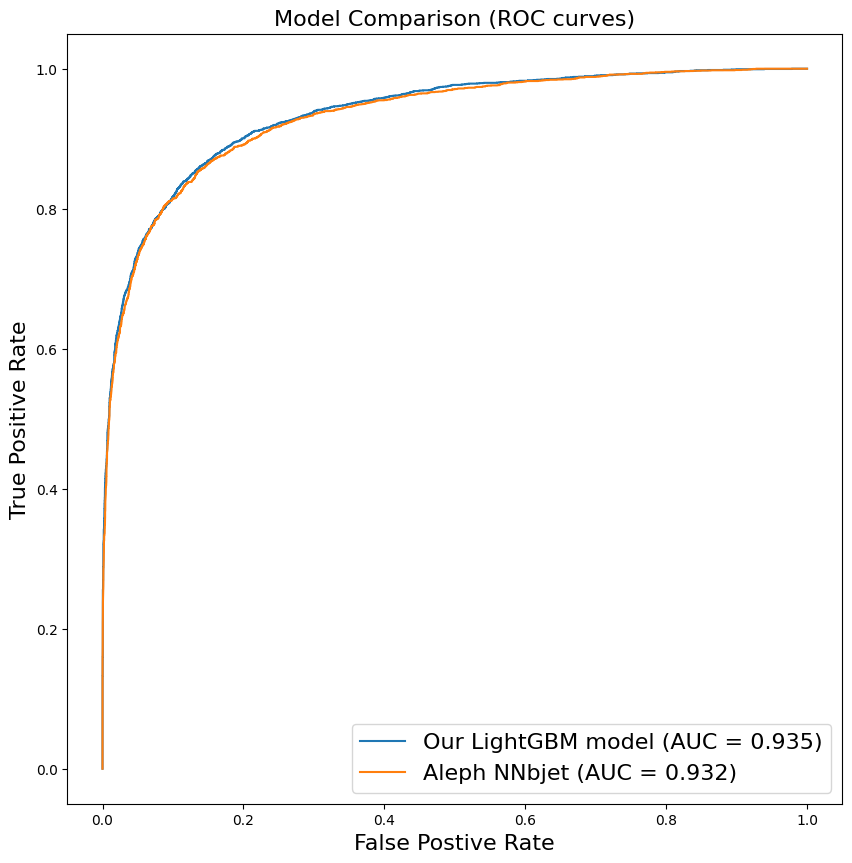

In [6]:
# Make predictions.
# NOTE the difference between 'score' (continuous in ]0,1[) and 'predictions' (integer: 0 or 1):
# Also NOTE that you can choose where to set the threshold (here set to 0.1)
y_score = gbm.predict(input_test, num_iteration=gbm.best_iteration)  # Scores are floats in the range ]0,1[.
y_pred  = [1 if pred > 0.1 else 0 for pred in y_score]               # Classify b-quark yes or no (for comparison).

# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score)                  # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the Area-Under-the-Curve (AUC) scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model Comparison (ROC curves)', size = 16)
plt.plot(fpr, tpr, label=f'Our LightGBM model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)
plt.show()

## Questions:

How well can you optimize the training/performance of your algorithm?

1. First try to simply do, what you might already have done: Change the HyperParameters (HPs) by hand (sometimes refered to as "Graduate student optimization"), and see if helps.

2. **Grid search**: Systematically try every combination of values from a predefined grid. If you test `n` values for each of `k` parameters, how many combinations will you end up having to test? Is this prohibitively large?<br>
NOTE: Check if Grid Search for HPs is a build in function before you code it up yourself.

3. **Random search**: Try 10 random combinations of parameters and keep the best.
NOTE: Check if Random Search for HPs is a build in function before you code it up yourself.


4. Which of the above approaches did you find most effective?

5. Are the best-performing solutions for the three search strategies clustered in a certain region of the parameter space? Try plotting the performance for a few values for each parameter dimension.

6. What happens if you remove Early Stopping?

7. How can you use Bayesian optimization to improve performance with less HPs testing?

## Learning points:

From this exercise you should:

- Know what hyperparameters are, and that they are important for optimizing ML algorithms.
- Know that grid search becomes computationally expensive quickly.
- Understand that random searchers can be surprisingly effective — and scales much better than grid search in high dimensions.
- Understand that the hard thing about random searches is figuring out the _right_ HP ranges 
- Understand that some parameters may be worth exploring more than others because they have a greater impact
- Realise that early stopping is great as it avoids overfitting and reduces run time
- Have at least a conceptual understanding that Bayesian optimization learns from past trials.

## Example Solution

We start by importing some functions that will be helpful

In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Define the LightGBM model
clf = lgb.LGBMClassifier(objective='binary', random_state=42)

The Grid search is painfully slow! To test `n` values for each of `k` parameters we need `k^n`searches. Therefore we start with this to let it run in the background

In [11]:
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 42],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 30]
}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1
)

grid_search.fit(input_train, truth_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 6772, number of negative: 23228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225733 -> initscore=-1.232562
[LightGBM] [Info] Start training from score -1.232562
[LightGBM] [Info] Number of positive: 6771, number of negative: 23229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train

GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='binary', random_state=42),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.1],
                         'min_child_samples': [20, 30],
                         'n_estimators': [100, 200], 'num_leaves': [31, 42]},
             scoring='roc_auc', verbose=1)

Let's have a look at the result of the Grid search

Best Grid Search AUC: 0.93299 found at iteration 26
Best Grid Search Parameters: {'boosting_type': 'dart', 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 31}


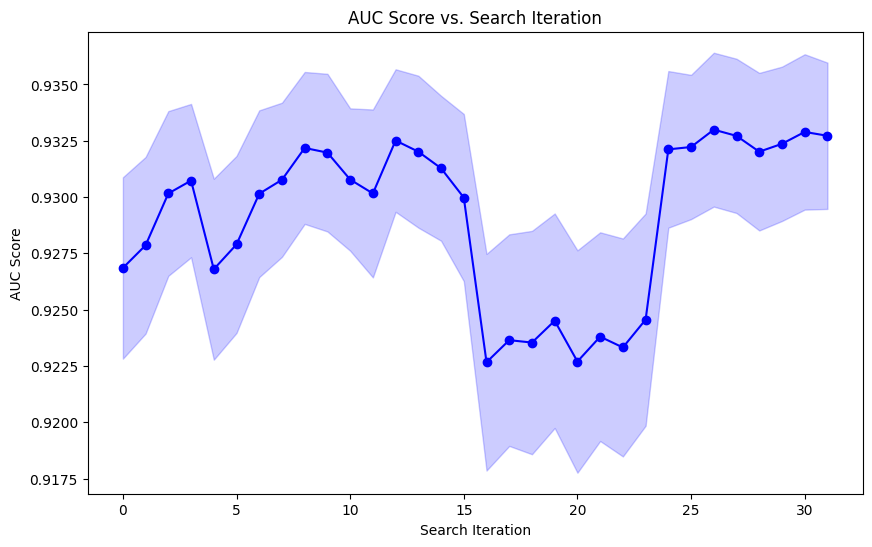

In [16]:
print(f"Best Grid Search AUC: {grid_search.best_score_:.5f} found at iteration {grid_search.best_index_}")
print(f"Best Grid Search Parameters: {grid_search.best_params_}")

# Plot the AUC score as a function of the number of searches:
mean_test_scores_grid = grid_search.cv_results_['mean_test_score']
std_test_scores_grid = grid_search.cv_results_['std_test_score']
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_test_scores_grid)), mean_test_scores_grid, marker='o', linestyle='-', color='b', label='AUC Score Grid Search')
plt.fill_between(range(len(mean_test_scores_grid)), 
                 mean_test_scores_grid - std_test_scores_grid, 
                 mean_test_scores_grid + std_test_scores_grid, 
                 color='b', alpha=0.2)
plt.xlabel('Search Iteration')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. Search Iteration')
plt.show()


In the meantime we will atempt the **grad sutdent search**. We start with the default values and see how good we can get

In [39]:
# Initialize dictonaries to save parameter combinations tried in grad student search
grad_auc = []
grad_params = []

In [51]:
manual_params ={
    'boosting_type': 'dart', 
    'learning_rate': 0.13, 
    'num_leaves': 55, 
    'n_estimators': 140, 
    'min_child_samples': 8,
    'bagging_freq': 0, # Set to a valid value => 0
    'bagging_fraction': 1., # Set to a valid value > 0 for rf
    'feature_fraction': 1., # Set to a valid value > 0 for rf
}

clf.set_params(**manual_params)
clf.fit(input_train, truth_train)
y_score = clf.predict_proba(input_test)[:, 1]
auc = roc_auc_score(truth_test, y_score)
print(f"AUC score: {auc:.5f}, Parameters: {manual_params}")
print(f"Number of searches: {len(grad_auc)+1}")
print(f"Best AUC score so far: {max(grad_auc):.5f} for parameters: {grad_params[grad_auc.index(max(grad_auc))]}")

# Update the lists with the results
grad_auc.append(auc)
grad_params.append(manual_params)

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] num_iterations is set=100, num_trees=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 

Try a few times before plotting the results of your grad student search vs. the results from the grid search

Best Graduent Search AUC: 0.93540 found at iteration 9
Best Graduent Search Parameters: {'boosting_type': 'dart', 'learning_rate': 0.11, 'num_leaves': 55, 'n_estimators': 140, 'min_child_samples': 8, 'bagging_freq': 0, 'bagging_fraction': 1.0, 'feature_fraction': 1.0}


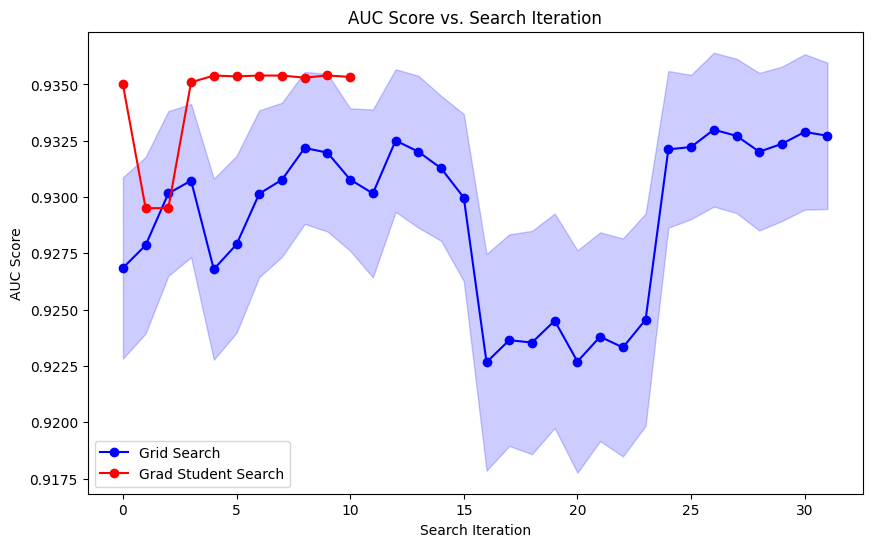

In [52]:
print(f"Best Graduent Search AUC: {max(grad_auc):.5f} found at iteration {grad_auc.index(max(grad_auc))}")
print(f"Best Graduent Search Parameters: {grad_params[grad_auc.index(max(grad_auc))]}")

# Plot the AUC score as a function of the number of searches:
mean_test_scores_grid_grid = grid_search.cv_results_['mean_test_score']
std_test_scores_grid_grid = grid_search.cv_results_['std_test_score']


plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_test_scores_grid)), mean_test_scores_grid, marker='o', linestyle='-', color='b', label='Grid Search')
plt.fill_between(range(len(mean_test_scores_grid)), 
                 mean_test_scores_grid - std_test_scores_grid, 
                 mean_test_scores_grid + std_test_scores_grid, 
                 color='b', alpha=0.2)
plt.plot(range(len(grad_auc)), grad_auc, marker='o', linestyle='-', color='r', label='Grad Student Search')

plt.xlabel('Search Iteration')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. Search Iteration')
plt.legend()
plt.show()
# Save the plots if requested:
if SavePlots:
    plt.savefig('AUC_vs_Search_Iteration.png')
    plt.close(fig)

Now let's see how a **random search** compares to our above results

In [28]:
from scipy.stats import uniform, randint

# Define parameter distributions
param_distributions = {
    'boosting_type': ['gbdt', 'dart', 'rf'],  # List of discrete values
    'learning_rate': uniform(0.01, 0.19),  # Continuous uniform distribution between 0.01 and 0.2
    'num_leaves': randint(20, 100),  # Integer values between 20 and 100
    'n_estimators': randint(50, 300),  # Integer values between 50 and 300
    'min_child_samples': randint(5, 50),  # Integer values between 5 and 50
    'bagging_freq': randint(1, 10),  # Integer values between 1 and 10
    'bagging_fraction': uniform(0.1, 0.8),  # Continuous uniform distribution between 0.1 and 0.9
    'feature_fraction': uniform(0.1, 0.8)  # Continuous uniform distribution between 0.1 and 0.9
}

# Perform RandomizedSearchCV with valid parameter distributions
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    verbose=1
)

random_search.fit(input_train, truth_train)

# Print the best results
print(f"Best Random Search AUC: {random_search.best_score_:.5f}")
print(f"Best Random Search Parameters: {random_search.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5774801263571896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774801263571896
[LightGBM] [Warning] bagging_fraction is set=0.39963209507789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39963209507789
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5774801263571896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774801263571896
[LightGBM] [Warning] bagging_fraction is set=0.39963209507789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39963209507789
[LightGBM] [Info] Number of positive: 6772, number of negative: 23228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

Best Random Search AUC: 0.93379 found at iteration 29
Best Random Search Parameters: {'bagging_fraction': np.float64(0.872335481031035), 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': np.float64(0.8061090745514717), 'learning_rate': np.float64(0.045854350584862084), 'min_child_samples': 45, 'n_estimators': 148, 'num_leaves': 38}


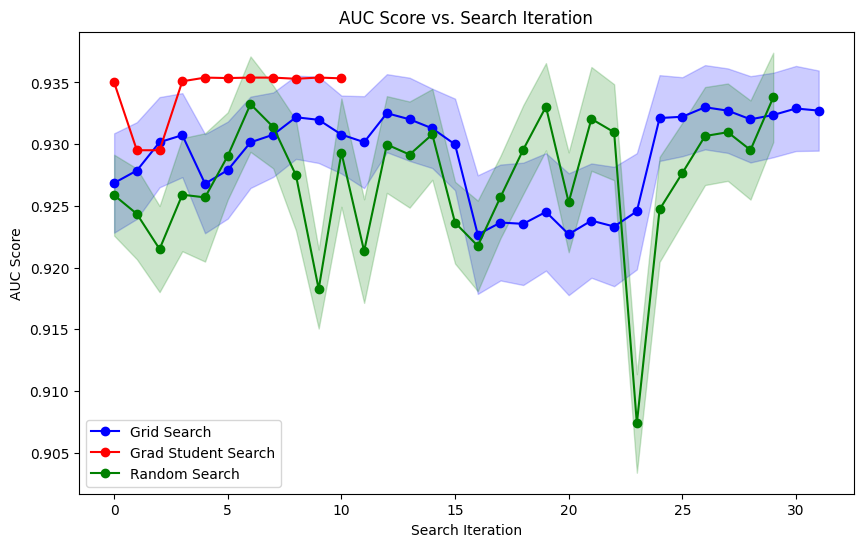

Best Grid Search AUC: 0.93299 found at iteration 26
Best Grid Search Parameters: {'boosting_type': 'dart', 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 31}
Best Grad Student Search AUC: 0.93540 found at iteration 9
Best Grad Student Search Parameters: {'boosting_type': 'dart', 'learning_rate': 0.11, 'num_leaves': 55, 'n_estimators': 140, 'min_child_samples': 8, 'bagging_freq': 0, 'bagging_fraction': 1.0, 'feature_fraction': 1.0}
Best Random Search AUC: 0.93379 found at iteration 29
Best Random Search Parameters: {'bagging_fraction': np.float64(0.872335481031035), 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': np.float64(0.8061090745514717), 'learning_rate': np.float64(0.045854350584862084), 'min_child_samples': 45, 'n_estimators': 148, 'num_leaves': 38}


In [54]:
print(f"Best Random Search AUC: {random_search.best_score_:.5f} found at iteration {random_search.best_index_}")
print(f"Best Random Search Parameters: {random_search.best_params_}")

# Plot the AUC score as a function of the number of searches:
mean_test_scores_grid_grid = grid_search.cv_results_['mean_test_score']
std_test_scores_grid_grid = grid_search.cv_results_['std_test_score']

mean_test_scores_random = random_search.cv_results_['mean_test_score']
std_test_scores_random = random_search.cv_results_['std_test_score']

plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_test_scores_grid)), mean_test_scores_grid, marker='o', linestyle='-', color='b', label='Grid Search')
plt.fill_between(range(len(mean_test_scores_grid)), 
                 mean_test_scores_grid - std_test_scores_grid, 
                 mean_test_scores_grid + std_test_scores_grid, 
                 color='b', alpha=0.2)

plt.plot(range(len(grad_auc)), grad_auc, marker='o', linestyle='-', color='r', label='Grad Student Search')


plt.plot(range(len(mean_test_scores_random)), mean_test_scores_random, marker='o', linestyle='-', color='g', label='Random Search')
plt.fill_between(range(len(mean_test_scores_random)),
                    mean_test_scores_random - std_test_scores_random, 
                    mean_test_scores_random + std_test_scores_random, 
                    color='g', alpha=0.2)

plt.xlabel('Search Iteration')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. Search Iteration')
plt.legend()
plt.show()
# Save the plots if requested:
if SavePlots:
    plt.savefig('AUC_vs_Search_Iteration.png')
    plt.close(fig)

# Print the best AUC score and the corresponding parameters from each search
print(f"Best Grid Search AUC: {grid_search.best_score_:.5f} found at iteration {grid_search.best_index_}")
print(f"Best Grid Search Parameters: {grid_search.best_params_}")
print(f"Best Grad Student Search AUC: {max(grad_auc):.5f} found at iteration {grad_auc.index(max(grad_auc))}")
print(f"Best Grad Student Search Parameters: {grad_params[grad_auc.index(max(grad_auc))]}")
print(f"Best Random Search AUC: {random_search.best_score_:.5f} found at iteration {random_search.best_index_}")
print(f"Best Random Search Parameters: {random_search.best_params_}")

Here we can see that **the random search was able to outperform the grid search**, although it wasn't significantly better. 
However, you can also see that the **HP ranges for the random search could have been chosen better**, as some combinations performed significantly worse.<br>
In particular, the way the code was set up, it chose a non-zero bagging frequency for a _Gradient Boosted Decision Tree_, because the default values of lightGBM would have resulted in an error for a _Random Forest_. This could have been fixed with a little tinkering, but this is to show that **random searches can be tricky** when not all HP combinations are possible.

In [57]:
manual_params ={
    'boosting_type': random_search.best_params_['boosting_type'],
    'learning_rate': random_search.best_params_['learning_rate'],
    'num_leaves': random_search.best_params_['num_leaves'],
    'n_estimators': random_search.best_params_['n_estimators'],
    'min_child_samples': random_search.best_params_['min_child_samples'],
    'bagging_freq': 0, # Set to a valid value => 0
    'bagging_fraction': 1., # Set to a valid value > 0 for rf
    'feature_fraction': 1., # Set to a valid value > 0 for rf
}

clf.set_params(**manual_params)
clf.fit(input_train, truth_train)
y_score = clf.predict_proba(input_test)[:, 1]
auc = roc_auc_score(truth_test, y_score)
print(f"AUC score: {auc:.5f}, Parameters: {manual_params}")

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] num_iterations is set=100, num_trees=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.